# Simulation einer QAM-Datenübertragung

## Systemmodell

Da sich dieses Jupyter-Notebook mit der Datenentscheidung und den Fehlerwahrscheinlichkeiten beschäftigt, gehen wir von einem zeitdiskreten Systemmodell aus, welches aus dem zeitkontinuierlichen System durch ideale Abtastung im Symboltakt hervorgeht. Bei idealer Filterung an Sender und Empfänger treten keine Intersymbolinterferenzen auf und das Empfangssymbol zu einem beliegiben Zeitpunkt lautet

\begin{equation}
    y = d + n \; .
\end{equation}

Dabei beschreibt $d$ das Datensymbol aus der Menge $\mathbb{D}$ und $n$ das additive, weiße, gaußverteilte Rauschen. Bei der Maximum-Likelihood-Detektion bestimmt der Empfänger nun dasjenige Symbol aus der Menge $\mathbb{D}$, welches den kleinsten euklidischen Abstand zum Empfangswert $y$ hat. Es gilt 

\begin{equation}
    \hat{d}^{\mathsf{ML}} = \arg \! \max_{\tilde{d} \in \mathbb{D}} p(y \mid \tilde{d})
     = \arg \! \min_{\tilde{d} \in \mathbb{D}} |y - \tilde{d}|^2 \; .
\end{equation}

In der folgenden Simulation wird ein zufälliger Vektor von Informationsbit $\mathbf{u}$ erzeugt, welcher dann ASK-moduliert wird. Anschließend wird auf die Datensymbole $\mathbf{d}$ weißes, gaußverteiltes Rauschen $\mathbf{n}$ addiert und aus den so erhaltenen Empfangssymbolen $\mathbf{y}$ die Datensymbole $\hat{\mathbf{d}}$ nach dem Maximum-Likelihood-Prinzip geschätzt. Die Detektionsfehler werden durch Vergleich mit der wahren Informationsbitfolge $\mathbf{d}$ ermittelt. Dabei wird Gray-Mapping und natürliches Mapping verwendet. 

## Analyse der 16-QAM 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import modulation as mod

# cardinality of modulation scheme
M = 16
m = int(np.log2(M))
m_ASK=int(m/2)

# number of information bits
N_info_bits = 400
N_symbols = int(N_info_bits / m)
# number of repetitions
N_runs = 1000

# signal-to-noise ratio and noise variance
SNRdB = np.linspace(0,30,16)
SNR = 10**(SNRdB/10)
# average transmit power (from lecture slides)
sigma2_D = 2*(M-1)/3.0
# noise variance of real and imaginary parts 
sigma2_N = sigma2_D / SNR / 2.0
sigma_N = np.sqrt(sigma2_N)

# initialize QAM object
QAM = mod.QAMModem(M)

ser_qam = np.zeros(len(SNRdB))
ber_qam = np.zeros(len(SNRdB))

for snr in np.arange(len(SNRdB)):
    
    err_symbols  = 0
    err_bits = 0
    
    # run over all repetitions
    for repetitions in np.arange(N_runs):
    
        # generate vector with information bits
        info_bits = np.random.randint(0,2,N_info_bits)
    
        # QAM modulation with Gray mapping
        d_qam = QAM.modulate(info_bits.flatten(),'gray')

        # AWGN
        awgn = np.random.normal(0,sigma_N[snr],N_symbols)+1j*np.random.normal(0,sigma_N[snr],N_symbols)
        y_qam = d_qam + awgn
        
        # detection of QAM symbols
        hat_info_bits_qam = QAM.demodulate(y_qam,'hard','gray')
        
        # determine number of errors
        compare_bits = np.where(info_bits == hat_info_bits_qam,0,1)
        err_bits  += np.sum(compare_bits)
        compare_symbols = np.sum(compare_bits.reshape((m,N_symbols)),axis=0)
        err_symbols += np.sum(np.where(compare_symbols == 0,0,1))
        
    ser_qam[snr] = err_symbols / N_symbols / N_runs
    ber_qam[snr] = err_bits / N_info_bits / N_runs

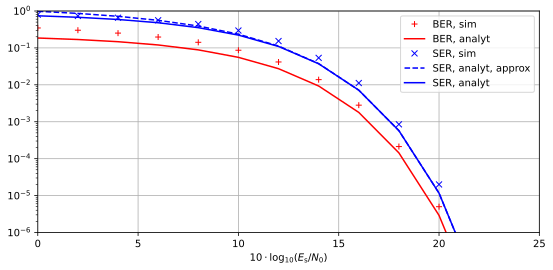

In [10]:
from scipy import special as sp

# analytical result
M_ASK = np.sqrt(M)
ser_analyt_qam_approx = 2*(M_ASK-1)/M_ASK * sp.erfc(np.sqrt(3/(2*(M-1))*SNR))
ser_analyt_qam = ser_analyt_qam_approx - (ser_analyt_qam_approx/2)**2
ber_analyt_qam = ser_analyt_qam / m

fig2 = plt.figure(figsize=(9,4))
ax2 = fig2.add_subplot(111)
ax2.semilogy(SNRdB, ber_qam, 'r+', label='BER, sim')
ax2.semilogy(SNRdB, ber_analyt_qam, 'r-', label='BER, analyt')
ax2.semilogy(SNRdB, ser_qam, 'bx', label='SER, sim')
ax2.semilogy(SNRdB, ser_analyt_qam_approx, 'b--', label='SER, analyt, approx')
ax2.semilogy(SNRdB, ser_analyt_qam, 'b-', label='SER, analyt')
plt.xlabel('$10 \cdot \log_{10}(E_{\mathrm{s}}/N_0)$')
plt.xlim(0,25)
plt.ylim(1e-6,1)
plt.grid(True)
plt.legend()

Bei der Symbolfehlerrate ist eine gute Übereinstimmung zwischen der analytischen Lösung und der Simulation (Marker) über den gesamten SNR-Bereich festzustellen. Die kleinen Abweichungen werden durch die endliche Anzahl an simulierten Datensymbolen hervorgerufen, die zu einer begrenzten Genauigkeit bei der Simulation der Fehlerrate führen. Die Approximation der analytische Lösung durch Vernachlässigen des quadratischen Terms führt nur für sehr kleine SNR zu einem sichtbaren Unterschied.

Dem obigen Bild ist ferner zu entnehmen, dass die Bitfehlerraten generell kleiner als die Symbolfehlerraten sind. Dies liegt daran, dass bei einem Symbolfehler nicht zwangsläufig alle Bit falsch entschieden werden müssen. Trotz einer falschen Symbolentscheidung können einzelne Bit richtig entschieden werden, so dass die Bitfehlerwahrscheinlichkeit niedriger als dieSymbolfehlerwahrscheinlichkeit ist. Bei Fehlentscheidungen werden vorwiegend benachbarte Symbole verwechselt. Dies gilt insbesonderen für mittlere und hohe SNR. Da sich benachbarte Symbole beim Gray-Mapping diese sich nur in einer Bitposition unterscheiden, ergibt sich die mittlere Bitfehlerwahrscheinlichkeit näherungsweise durch

\begin{equation}
    P_{\mathrm{b}} \approx \frac{P_{\mathrm{s}}}{m}
\end{equation}

aus der Symbolfehlerrate $P_{\mathrm{s}}$. Die simulierten Bitfehlerraten liegen durchweg über den analytischen Werten. Dies liegt daran, dass mit der obigen Formel eine Gray-Codierung für die gesamte QAM angenommen wurde, während in der Simulation das Gray-Mapping für Real- und Imaginärteil getrennt angewandt wurde.

Bei Gray-Codierung unterscheiden sich benachbarte Symbole nur durch 1 Bit in ihrer binären Darstellung. Da Fehler am häufigsten durch das Vertauschen benachbarter Symbole entstehen, wird bei diesen Fehlerereignissen nur eines von $m$ Bit verfälscht. Damit gilt für die Bitfehlerwahrscheinlichkeit näherungsweise

\begin{equation}
    P_{\mathrm{b}} \approx \frac{P_{\mathrm{s}}}{m} \; .
\end{equation}